In [1]:
import numpy as np
from qiskit.primitives import BitArray
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_addon_sqd.counts import bit_array_to_arrays
from qiskit_addon_sqd.subsampling import subsample, postselect_and_subsample
from qiskit_addon_sqd.qubit import solve_qubit
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from dataclasses import dataclass
from typing import Callable


@dataclass(frozen=True)
class TFIMResult:
    """Result of a TFIM SQD calculation."""
    energy: float
    amplitudes: np.ndarray
    bitstrings: np.ndarray
    magnetization_z: float
    subspace_dimension: int

In [2]:
def create_tfim_hamiltonian(num_qubits: int, h_field: float = 1.0, J_coupling: float = 1.0) -> SparsePauliOp:
    """Create TFIM Hamiltonian: H = -J * sum_i Z_i Z_{i+1} - h * sum_i X_i"""
    pauli_ops = []
    coeffs = []
    
    # ZZ coupling terms
    for i in range(num_qubits - 1):  # Open boundary conditions
        pauli_str = ['I'] * num_qubits
        pauli_str[i] = 'Z'
        pauli_str[i+1] = 'Z'
        pauli_ops.append(Pauli(''.join(pauli_str)))
        coeffs.append(-J_coupling)
    
    # X field terms
    for i in range(num_qubits):
        pauli_str = ['I'] * num_qubits
        pauli_str[i] = 'X'
        pauli_ops.append(Pauli(''.join(pauli_str)))
        coeffs.append(-h_field)
    
    return SparsePauliOp(pauli_ops, coeffs)

In [3]:
def compute_magnetization_z(bitstrings: np.ndarray, amplitudes: np.ndarray) -> float:
    """Compute Z-magnetization from state."""
    # Convert 0,1 to -1,+1 and compute expectation value
    z_values = 2 * bitstrings.astype(int) - 1  
    mag_per_config = np.sum(z_values, axis=1)
    probabilities = np.abs(amplitudes)**2
    probabilities /= np.sum(probabilities)
    return float(np.sum(probabilities * mag_per_config))

In [ ]:
def diagonalize_tfim_hamiltonian(
    hamiltonian: SparsePauliOp,
    bit_array: BitArray,
    samples_per_batch: int,
    num_qubits: int,
    *,
    num_batches: int = 1,
    energy_tol: float = 1e-8,
    magnetization_tol: float = 1e-5,
    max_iterations: int = 100,
    target_hamming_weight: int | None = None,
    callback: Callable[[list[TFIMResult]], None] | None = None,
    seed: int | np.random.Generator | None = None,
) -> TFIMResult:
    """
    TFIM version of diagonalize_fermionic_hamiltonian.
    
    Args:
        hamiltonian: TFIM Hamiltonian as SparsePauliOp
        bit_array: Sampled bitstrings from quantum device
        samples_per_batch: Number of samples per batch
        num_qubits: Number of qubits
        num_batches: Number of batches per iteration
        energy_tol: Energy convergence tolerance
        magnetization_tol: Magnetization convergence tolerance
        max_iterations: Maximum iterations
        target_hamming_weight: Postselect on this Hamming weight
        callback: Callback function for progress tracking
        seed: Random seed
        
    Returns:
        TFIMResult with ground state information
    """
    rng = np.random.default_rng(seed)
    
    # Convert BitArray to arrays - reuse existing function
    raw_bitstrings, raw_probs = bit_array_to_arrays(bit_array)
    
    if raw_bitstrings.shape[1] != num_qubits:
        raise ValueError(f"BitArray has {raw_bitstrings.shape[1]} qubits but expected {num_qubits}")
    
    current_magnetization = None
    best_result = None
    current_result = None
    carryover_strings = np.array([], dtype=bool).reshape(0, num_qubits)
    
    for iteration in range(max_iterations):
        print(f"\n=== Iteration {iteration + 1} ===")
        if iteration == 1:
            print(f"Starting TFIM diagonalization with {num_qubits} qubits, {len(raw_bitstrings)} samples")
 
        if current_magnetization is not None:
            # Use magnetization for configuration recovery
            # Map magnetization to "pseudo-occupancies" for the existing function
            avg_mag_per_qubit = current_magnetization / num_qubits
            avg_up_occ = 0.5 + avg_mag_per_qubit / 2
            avg_down_occ = 0.5 - avg_mag_per_qubit / 2
            
            avg_occupancies = (
                np.full(num_qubits, avg_up_occ),
                np.full(num_qubits, avg_down_occ)
            )
 
            # print avg_occupancies for debugging
            print(f"Avg occupancies: {avg_occupancies[0]}, {avg_occupancies[1]}")
            
            # Reuse existing configuration recovery
            bitstrings, probs = recover_configurations(
                raw_bitstrings, raw_probs, avg_occupancies,
                target_hamming_weight or num_qubits // 2,
                target_hamming_weight or num_qubits // 2,
                rand_seed=rng
            )
            print(f"After config recovery: {len(bitstrings)} bitstrings")
        else:
            bitstrings, probs = raw_bitstrings, raw_probs
        
        # Add carryover configurations
        if len(carryover_strings) > 0:
            all_bitstrings = np.vstack([bitstrings, carryover_strings])
            carryover_probs = np.full(len(carryover_strings), 1e-6)
            all_probs = np.concatenate([probs, carryover_probs])
            all_probs = all_probs / np.sum(all_probs)
            bitstrings, probs = all_bitstrings, all_probs
        
        # Subsample batches - reuse existing function
        subsamples = subsample(
            bitstrings,
            probs,
            hamming_right=target_hamming_weight or num_qubits // 2,
            hamming_left=0,
            samples_per_batch=samples_per_batch,
            num_batches=num_batches,
            rand_seed=rng,
        )
        print(f"Created {len(subsamples)} batches")
 
        
        # Solve in each subspace - reuse existing solve_qubit function
        results = []
        # iterate with index to match subsample structure
        for idx, sample_batch in enumerate(subsamples):
            print(f"  Batch {idx}: {len(sample_batch)} samples")
            if len(sample_batch) == 0:
                continue
 
            # Remove duplicate bitstrings to avoid dimension issues            
            unique_bitstrings, unique_indices = np.unique(sample_batch, axis=0, return_index=True)            
            if len(unique_bitstrings) == 0:                
                continue

            print(f" Unique bitstrings: {len(unique_bitstrings)}")
            print(f" Hamiltonian: {hamiltonian}")
            
            # This is the key reuse - solve_qubit works directly with SparsePauliOp!
            # try:
            energies, eigenstates = solve_qubit(
                unique_bitstrings,
                hamiltonian,
                k=1,  # Just ground state
                which='SA'  # Smallest algebraic
            )
            
            ground_state_amplitudes = eigenstates[:, 0]
            magnetization_z = compute_magnetization_z(unique_bitstrings, ground_state_amplitudes)
            
            result = TFIMResult(
                energy=energies[0],
                amplitudes=ground_state_amplitudes,
                bitstrings=unique_bitstrings,
                magnetization_z=magnetization_z,
                subspace_dimension=len(ground_state_amplitudes)
            )
            results.append(result)
                
            # except Exception as e:
            #     print(f"Warning: Solver failed for batch with {len(unique_bitstrings)} configs: {e}")
            #     continue
        
        if not results:
            continue
        
        # Call callback - reuse pattern from fermion.py
        if callback is not None:
            callback(results)
        
        # Get best result
        best_result_in_batch = min(results, key=lambda r: r.energy)
        
        if best_result is None or best_result_in_batch.energy < best_result.energy:
            best_result = best_result_in_batch
        
        # Check convergence
        if (current_result is not None and
            abs(current_result.energy - best_result_in_batch.energy) < energy_tol and
            abs(current_result.magnetization_z - best_result_in_batch.magnetization_z) < magnetization_tol):
            break
        
        current_result = best_result_in_batch
        current_magnetization = current_result.magnetization_z
        
        # Carryover important configurations
        amplitudes = best_result_in_batch.amplitudes
        amp_magnitudes = np.abs(amplitudes)
        threshold = 0.01 * np.max(amp_magnitudes)
        important_indices = amp_magnitudes > threshold
        carryover_strings = best_result_in_batch.bitstrings[important_indices]
    
    return best_result

In [5]:
num_qubits = 8
h_field = 0.5
J_coupling = 1.0
hamiltonian = create_tfim_hamiltonian(num_qubits, h_field, J_coupling)

In [7]:
from qiskit import QuantumCircuit, QuantumRegister
 
# Generate the initial state at 1
qubits = QuantumRegister(num_qubits, name="q")
init_state = QuantumCircuit(qubits)
# Set the all to |1>
for i in range(num_qubits):
    init_state.x(i)
init_state.draw("mpl", scale=0.4, fold=-1)
 
dt = 0.5 # Time step
d = 10  # Number of Krylov basis states
 
# X field evolution = parallel RX gates
def x_field_evolution(qc, phi):
    """Apply exp(-i phi ∑ Xᵢ) = ∏ exp(-i phi Xᵢ)"""
    for i in range(num_qubits):
        qc.rx(2 * phi, i)  # Much simpler than orbital rotations!
 
# ZZ evolution = CNOT + RZ + CNOT pattern
def zz_evolution(qc, i, j, theta):
    """Apply exp(-i theta ZᵢZⱼ)"""
    qc.cx(i, j)
    qc.rz(2 * theta, j)
    qc.cx(i, j)
 
def zz_layer(qc, theta):
    """Apply ZZ evolution to all nearest neighbor pairs"""
    for i in range(num_qubits - 1):
        zz_evolution(qc, i, i + 1, theta)
 
circuits = []
for i in range(d):
    circ = init_state.copy()
    circuits.append(circ)
    for _ in range(i):
        zz_layer(circ, J_coupling * dt / 2)
        x_field_evolution(circ, h_field * dt)
        zz_layer(circ, J_coupling * dt / 2)
    circ.measure_all()

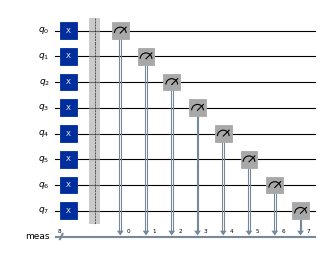

In [8]:
circuits[0].draw("mpl", scale=0.4, fold=-1)

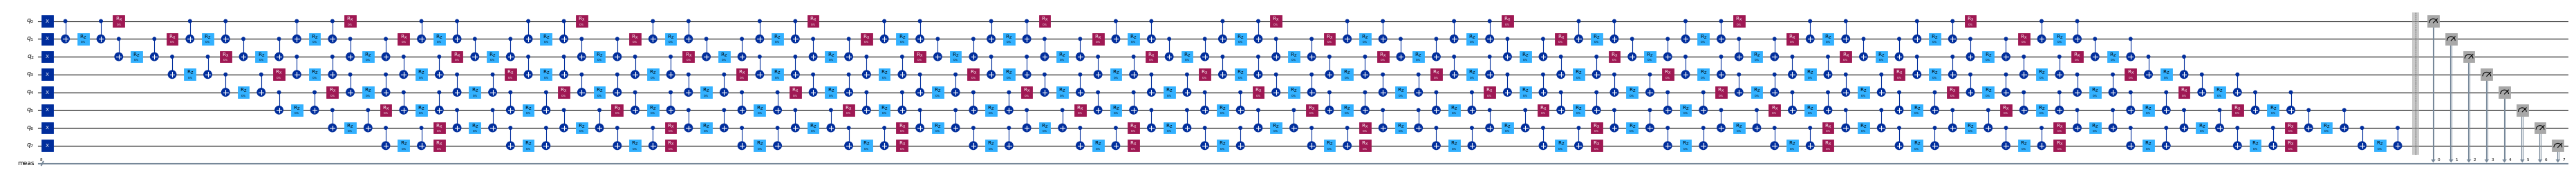

In [10]:
circuits[-1].draw("mpl", scale=0.4, fold=-1)

In [11]:
from dotenv import load_dotenv
import os

load_dotenv()

token = os.getenv("QISKIT_IBM_RUNTIME_TOKEN")
instance = os.getenv("QISKIT_IBM_RUNTIME_INSTANCE")

In [48]:
from qiskit_ibm_runtime.fake_provider.backends import FakeSherbrooke
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit_ibm_runtime import QiskitRuntimeService

# backend = FakeAlmadenV2()

service = QiskitRuntimeService(channel='ibm_cloud', token=token, instance=instance)
backend = service.least_busy(simulator=False, operational=True)
print(f"Using backend: {backend}")

Using backend: <IBMBackend('ibm_aachen')>


In [49]:
from qiskit.transpiler import generate_preset_pass_manager

# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuits = pass_manager.run(circuits)

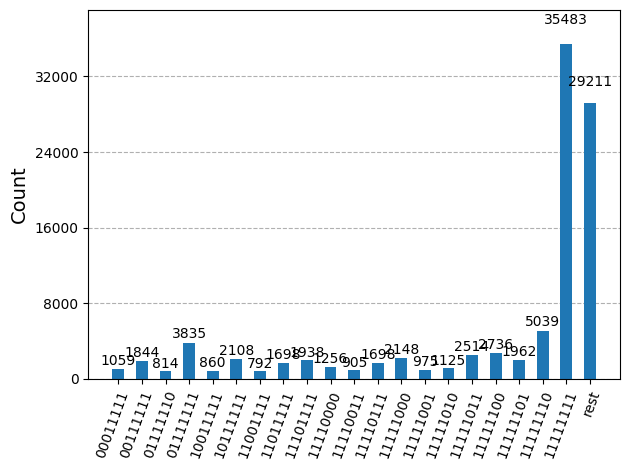

In [50]:
from qiskit.primitives import BitArray
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Sample from the circuits
noisy_sampler = Sampler(backend)
job = noisy_sampler.run(isa_circuits, shots=10000)

# Combine the counts from the individual Trotter circuits
bit_array = BitArray.concatenate_shots([result.data.meas for result in job.result()])

plot_histogram(bit_array.get_counts(), number_to_keep=20)

In [52]:
import numpy as np

np.save("bit_array_sqd.npy", bit_array.array)

In [62]:
result_history = []
    
def callback(results: list[TFIMResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy}")
        print(f"\t\tSubspace dimension: {result.subspace_dimension}")
        print(f"\t\tMagnetization_z: {result.magnetization_z:.4f}")

# Step 4: Call diagonalize function (same pattern as fermion)
rng = np.random.default_rng(24)
result = diagonalize_tfim_hamiltonian(
    hamiltonian,
    bit_array,
    samples_per_batch=300,
    num_qubits=num_qubits,
    num_batches=3,
    max_iterations=10,
    callback=callback,
    seed=rng,
    # target_hamming_weight=num_qubits,  # Postselect on half-up, half-down
)


=== Iteration 1 ===
Created 3 batches
  Batch 0: 1 samples
 Unique bitstrings: 1
 Hamiltonian: SparsePauliOp(['ZZIIIIII', 'IZZIIIII', 'IIZZIIII', 'IIIZZIII', 'IIIIZZII', 'IIIIIZZI', 'IIIIIIZZ', 'XIIIIIII', 'IXIIIIII', 'IIXIIIII', 'IIIXIIII', 'IIIIXIII', 'IIIIIXII', 'IIIIIIXI', 'IIIIIIIX'],
              coeffs=[-1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j,
 -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j])


TypeError: Cannot use scipy.linalg.eig for sparse A with k >= N - 1. Use scipy.linalg.eig(A.toarray()) or reduce k.

Exact energy: -7.64059
SQD energy: -7.63638
Absolute error: 0.00422


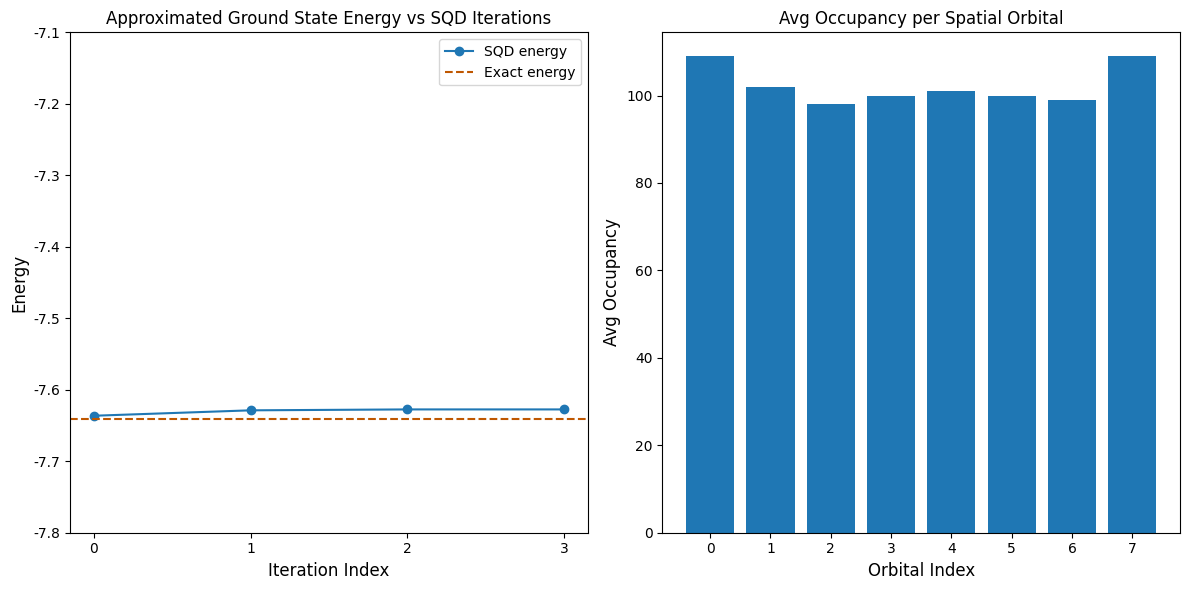

Final SQD energy: -7.63638
Iteration 1:
	Subsample 0: Energy = -7.63638, Magnetization_z = 7.4756, Subspace dimension = 196
	Subsample 1: Energy = -7.63638, Magnetization_z = 7.4756, Subspace dimension = 196
	Subsample 2: Energy = -7.63638, Magnetization_z = 7.4756, Subspace dimension = 196
Iteration 2:
	Subsample 0: Energy = -7.62879, Magnetization_z = 7.5220, Subspace dimension = 56
	Subsample 1: Energy = -7.62879, Magnetization_z = 7.5220, Subspace dimension = 56
	Subsample 2: Energy = -7.62879, Magnetization_z = 7.5220, Subspace dimension = 56
Iteration 3:
	Subsample 0: Energy = -7.62751, Magnetization_z = 7.5291, Subspace dimension = 49
	Subsample 1: Energy = -7.62751, Magnetization_z = 7.5291, Subspace dimension = 49
	Subsample 2: Energy = -7.62751, Magnetization_z = 7.5291, Subspace dimension = 49
Iteration 4:
	Subsample 0: Energy = -7.62751, Magnetization_z = 7.5291, Subspace dimension = 49
	Subsample 1: Energy = -7.62751, Magnetization_z = 7.5291, Subspace dimension = 49
	Subs

In [43]:
import matplotlib.pyplot as plt

exact_energy = -7.640592553590086
min_es = [min(result, key=lambda res: res.energy).energy for result in result_history]
min_id, min_e = min(enumerate(min_es), key=lambda x: x[1])

# Data for energies plot
x1 = range(len(result_history))
yt1 = list(np.arange(-7.8, -7.1, 0.1))
ytl = [f"{i:.1f}" for i in yt1]

# Data for avg spatial orbital occupancy
y2 = np.sum(result.bitstrings, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, min_es, label="SQD energy", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(ytl)
axs[0].axhline(y=exact_energy, color="#BF5700", linestyle="--", label="Exact energy")
axs[0].set_title("Approximated Ground State Energy vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:.5f}")
print(f"SQD energy: {min_e:.5f}")
print(f"Absolute error: {abs(min_e - exact_energy):.5f}")
plt.tight_layout()
plt.show()

print(f"Final SQD energy: {result.energy:.5f}")
# loop all result history
for i, res in enumerate(result_history):
    print(f"Iteration {i + 1}:")
    for j, r in enumerate(res):
        print(f"\tSubsample {j}: Energy = {r.energy:.5f}, Magnetization_z = {r.magnetization_z:.4f}, Subspace dimension = {r.subspace_dimension}")

In [33]:
def tfim_exact_small_system(num_qubits: int, h_field: float, J_coupling: float = 1.0) -> tuple[float, np.ndarray]:
    """
    Method 1: Full exact diagonalization (only for small systems, N <= 12-14)
    Uses the solve_qubit function with all possible bitstrings.
    """
    if num_qubits > 14:
        raise ValueError(f"System too large for exact diagonalization: {num_qubits} qubits = {2**num_qubits} states")
    
    # Create TFIM Hamiltonian
    hamiltonian = create_tfim_hamiltonian(num_qubits, h_field, J_coupling)
    
    # Generate all possible bitstrings
    all_bitstrings = np.array([
        [(i >> j) & 1 for j in range(num_qubits)] 
        for i in range(2**num_qubits)
    ], dtype=bool)
    
    print(f"Exact diagonalization of {num_qubits}-qubit TFIM ({2**num_qubits} states)")
    
    # Use the existing solve_qubit function
    energies, eigenstates = solve_qubit(
        all_bitstrings, 
        hamiltonian,
        k=1,  # Just ground state
        which='SA'
    )
    
    return energies[0], eigenstates[:, 0]

In [34]:
small_hamiltonian = tfim_exact_small_system(num_qubits, h_field, J_coupling)
small_hamiltonian

Exact diagonalization of 8-qubit TFIM (256 states)


(np.float64(-7.640592553590086),
 array([-0.1336318 +0.60980433j, -0.03355589+0.15312616j,
        -0.01784084+0.08141344j, -0.01295485+0.0591171j ,
        -0.01714   +0.07821527j, -0.00464243+0.02118489j,
        -0.00507244+0.02314718j, -0.0062184 +0.02837652j,
        -0.0170668 +0.07788124j, -0.00435518+0.01987406j,
        -0.00238807+0.0108975j , -0.00202392+0.00923579j,
        -0.00458354+0.02091616j, -0.00154319+0.00704205j,
        -0.00221033+0.01008645j, -0.00454286+0.0207305j ,
        -0.0170668 +0.07788124j, -0.00432296+0.01972704j,
        -0.00231334+0.01055649j, -0.00180352+0.00823005j,
        -0.00227521+0.01038252j, -0.00068419+0.00312216j,
        -0.00081893+0.00373705j, -0.00143437+0.00654547j,
        -0.00453007+0.02067214j, -0.00128393+0.00585897j,
        -0.00078009+0.00355981j, -0.00114874+0.00524207j,
        -0.00189137+0.00863093j, -0.00111838+0.00510354j,
        -0.00192642+0.00879088j, -0.0062184 +0.02837652j,
        -0.01714   +0.07821527j, -0.004